In [53]:
def plot_scatter(df):
    import plotly.express as px
    import pandas as pd
    import math
    
    # Apply log scale to lr for the plot
    df['log_lr'] = df['lr'].apply(lambda x: math.log2(x))
    
    # Creating the plot
    fig = px.line(df, x='log_lr', y='train_loss',
                  color='width',  # This separates the lines by width
                  hover_data=['width'],  # This adds the width to the hover information
                  title='Training Loss vs. Log-Scaled Learning Rate',
                  labels={'log_lr': 'Log Scale Learning Rate (log2(lr))', 'train_loss': 'Training Loss', 'width': 'Width'})
    
    # Update the line titles to include the width value
    for width, trace in zip(df['width'].unique(), fig.data):
        trace.name = f'Width: {width}'

    y_min = df['train_loss'].min()  # Adjust the lower bound as needed
    y_max = 0.1  # Adjust the upper bound as needed
    fig.update_yaxes(range=[y_min, y_max])
    
    return fig

In [54]:
def extract_runs(is_mup):
    target_runs = []
    for run in runs:
        # if run.config["config"]["num_layers"] == num_layers and run.config["config"]["batch_size"] == batch_size:
        #     # train_loss = run.history()["mup_loss"].iloc[-1]
        #     # eval_loss = run.history()["ref_eval_loss"].iloc[-1]
        if is_mup:
            train_loss = run.summary["mup_loss"]
            eval_loss = run.summary["mup_eval_loss"]
        else:
            train_loss = run.summary["ref_loss"]
            eval_loss = run.summary["ref_eval_loss"]

        # eval_loss = 99 if eval_loss == "nan" else eval_loss
        lr = run.config["config"]["lr"]
        width = run.config["config"]["target_width"]
        target_runs.append((train_loss, eval_loss, lr, width))

    # Assuming target_runs is prepared with your data
    # Convert target_runs to a DataFrame for easier manipulation with Plotly
    import pandas as pd
    df = pd.DataFrame(target_runs, columns=['train_loss', 'eval_loss', 'lr', 'width'])
    return df

In [55]:
def _extract_runs(is_mup, step):
    target_runs = []
    for run in runs:
        # if run.config["config"]["num_layers"] == num_layers and run.config["config"]["batch_size"] == batch_size:
        #     # train_loss = run.history()["mup_loss"].iloc[-1]
        #     # eval_loss = run.history()["ref_eval_loss"].iloc[-1]
        if is_mup:
            train_loss = run.history(20_000)["mup_loss"].iloc[step]
            eval_loss = run.summary["mup_eval_loss"]
        else:
            train_loss = run.history(20_000)["ref_loss"].iloc[step]
            eval_loss = run.summary["ref_eval_loss"]

        # eval_loss = 99 if eval_loss == "nan" else eval_loss
        lr = run.config["config"]["lr"]
        width = run.config["config"]["target_width"]
        target_runs.append((train_loss, eval_loss, lr, width))

    # Assuming target_runs is prepared with your data
    # Convert target_runs to a DataFrame for easier manipulation with Plotly
    import pandas as pd
    df = pd.DataFrame(target_runs, columns=['train_loss', 'eval_loss', 'lr', 'width'])
    return df

In [56]:
import wandb

api = wandb.Api()
entity, project = "neuralink", "exp20_single_mup_adam_bs_64_20_epochs"  # set to your entity and project 
runs = api.runs(entity + "/" + project)

In [57]:
runs[0].name

'width_8192_and_bs_64_and_lr_6.103515625e-05_92.37M'

In [60]:
runs[0].summary["mup_loss"]

1.9651405811309817

### Mup

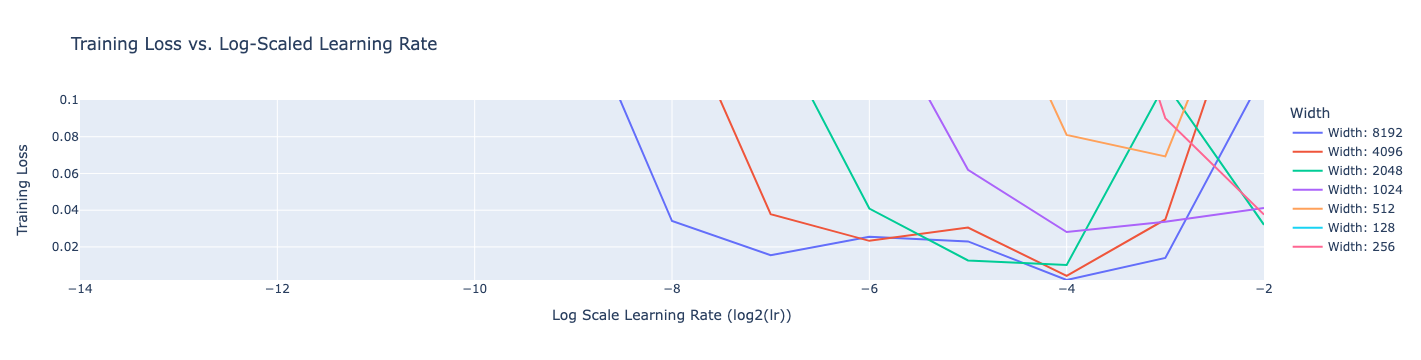

In [61]:
mup_df = extract_runs(is_mup=True)
plot_scatter(mup_df).show()

In [65]:
mup_df

,train_loss,eval_loss,lr,width,log_lr
0,1.965141,1.531107,0.000061,8192,-14.0
1,1.715621,1.458656,0.000122,8192,-13.0
2,1.364234,1.361714,0.000244,8192,-12.0
3,0.950698,1.271142,0.000488,8192,-11.0
4,0.522398,1.294468,0.000977,8192,-10.0
...,...,...,...,...,...
86,0.032030,4.044926,0.250000,2048,-2.0
87,0.041199,3.985866,0.250000,1024,-2.0
88,0.202851,4.019954,0.250000,512,-2.0
89,0.037572,2.495376,0.250000,256,-2.0


In [73]:
mup_df.groupby('width').agg({
    'train_loss': 'min',
})

,train_loss
width,
128,0.273503
256,0.037572
512,0.069266
1024,0.028136
2048,0.010167
4096,0.004197
8192,0.001987


In [79]:
idx = mup_df.groupby('width')['train_loss'].idxmin()
result_df = mup_df.loc[idx, ['train_loss', 'lr', "width"]]

In [80]:
result_df

,train_loss,lr,width
90,0.273503,0.2500,128
89,0.037572,0.2500,256
81,0.069266,0.1250,512
74,0.028136,0.0625,1024
73,0.010167,0.0625,2048
71,0.004197,0.0625,4096
61,0.001987,0.0625,8192


In [68]:
mup_df.groupby('width').agg({
    'train_loss': 'min',
    'lr': 'first'
})

,train_loss,lr
width,,
128,0.273503,0.000061
256,0.037572,0.000061
512,0.069266,0.000061
1024,0.028136,0.000061
2048,0.010167,0.000061
4096,0.004197,0.000061
8192,0.001987,0.000061


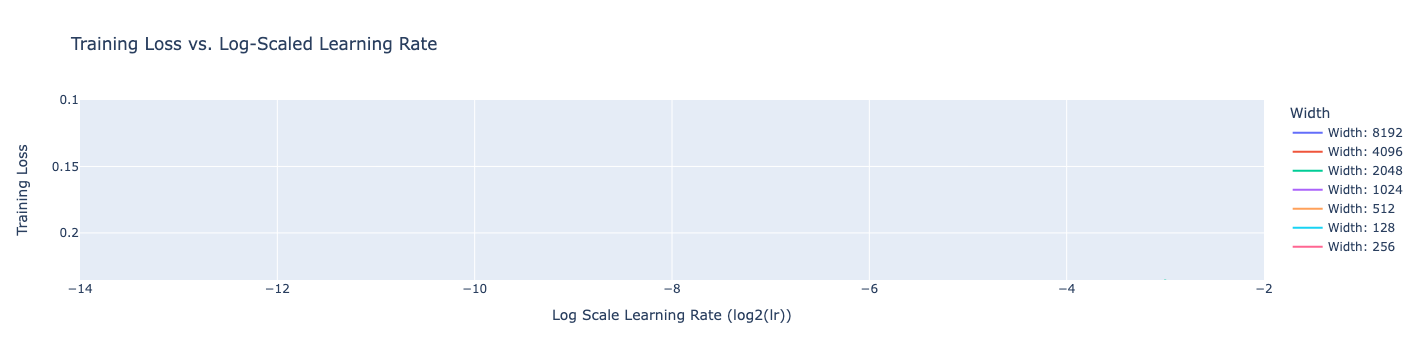

In [44]:
mup_df = _extract_runs(is_mup=True, step=8000)
plot_scatter(mup_df).show()

In [24]:
mup_result = mup_df.groupby('width').agg({
    'train_loss': 'min',
    'eval_loss': 'min'
}).reset_index()

In [25]:
mup_result

,width,train_loss,eval_loss
0,128,0.273503,1.273957
1,256,0.037572,1.248066
2,512,0.069266,1.263548
3,1024,0.028136,1.241532
4,2048,0.010167,1.241047
5,4096,0.004197,1.230727
6,8192,0.001987,1.271142


### Reference

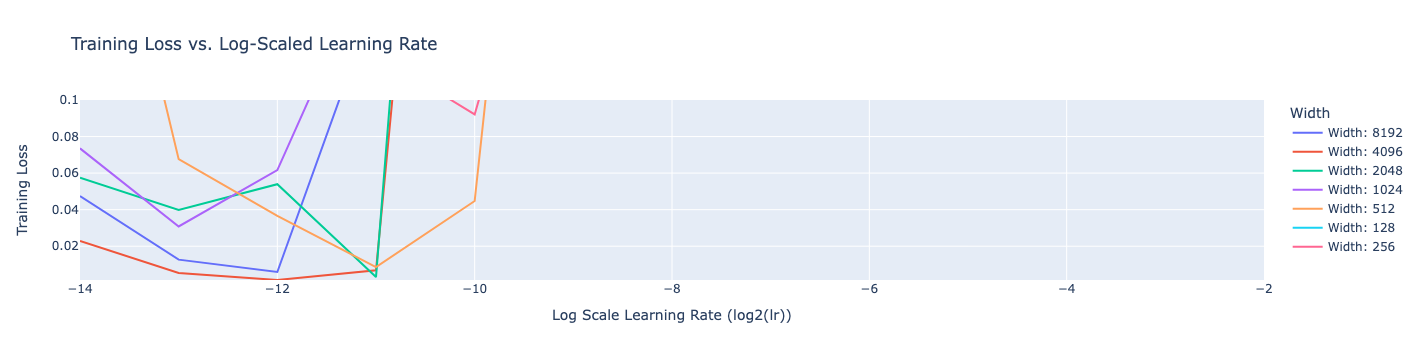

In [69]:
ref_df = extract_runs(is_mup=False)
plot_scatter(ref_df).show()

In [70]:
ref_df.groupby('width').agg({
    'train_loss': 'min',
    'lr': 'first'
})

,train_loss,lr
width,,
128,0.202025,0.000061
256,0.092089,0.000061
512,0.008604,0.000061
1024,0.030812,0.000061
2048,0.003108,0.000061
4096,0.001510,0.000061
8192,0.005901,0.000061


In [82]:
ref_df_idx = ref_df.groupby('width')['train_loss'].idxmin()
ref_df.loc[ref_df_idx, ['train_loss', 'lr', "width"]]

,train_loss,lr,width
30,0.202025,0.000488,128
38,0.092089,0.000977,256
29,0.008604,0.000488,512
15,0.030812,0.000122,1024
27,0.003108,0.000488,2048
18,0.001510,0.000244,4096
2,0.005901,0.000244,8192


In [ ]:
mup_df = _extract_runs(is_mup=False, step=8000)
plot_scatter(mup_df).show()

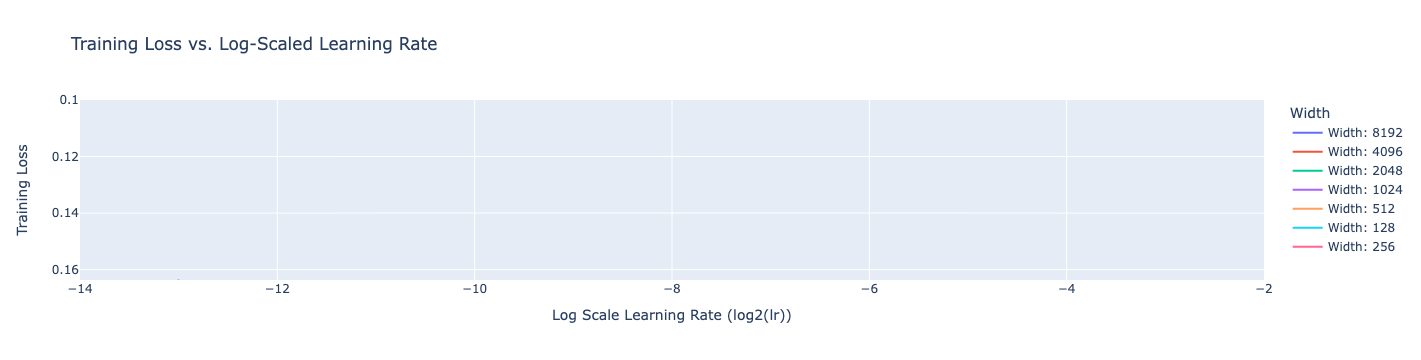

In [46]:
plot_scatter(mup_df).show()

In [26]:
ref_result = ref_df.groupby('width').agg({
    'train_loss': 'min',
    'eval_loss': 'min'
}).reset_index()

In [27]:
ref_result

,width,train_loss,eval_loss
0,128,0.202025,1.274036
1,256,0.092089,1.183155
2,512,0.008604,1.415840
3,1024,0.030812,1.849798
4,2048,0.003108,2.169273
5,4096,0.001510,1.185619
6,8192,0.005901,1.594732


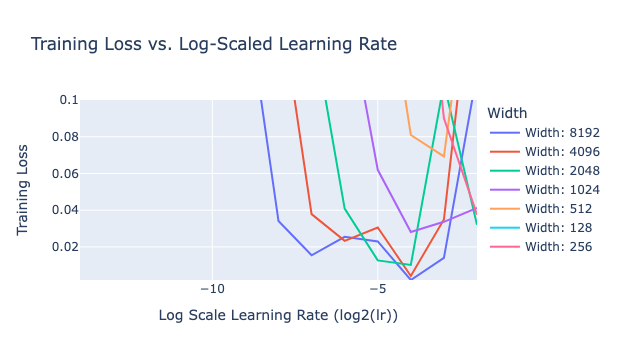

In [8]:
plot_scatter(extract_runs(is_mup=True)).show()

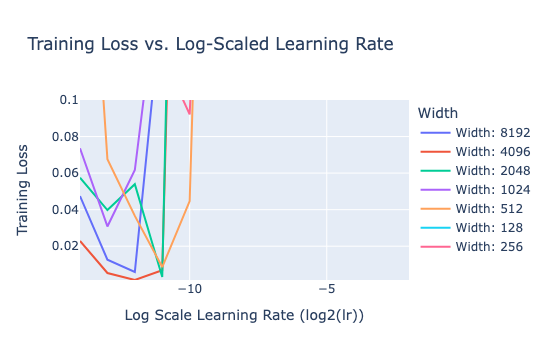

In [47]:
plot_scatter(extract_runs(is_mup=False)).show()

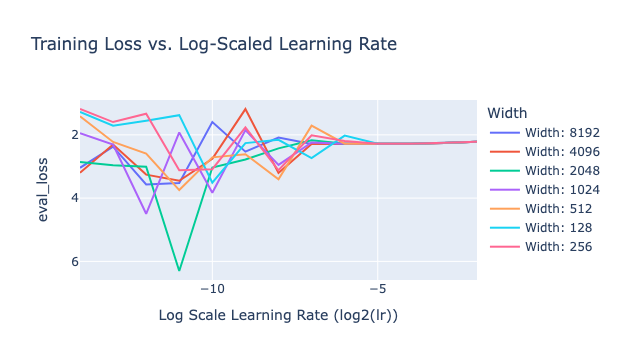

In [22]:
plot_scatter(extract_runs(is_mup=False)).show()

In [71]:
mup_df_200 = _extract_runs(is_mup=False, step=8000)
# plot_scatter(mup_df_200).show()

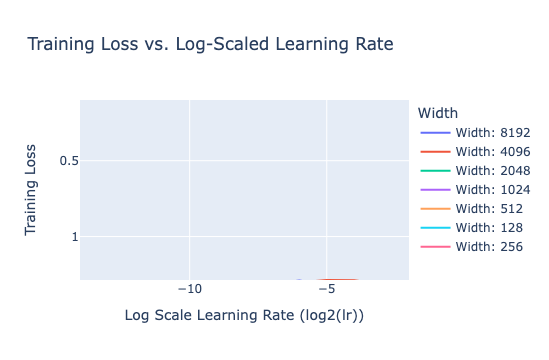

In [51]:
_mup_df_200 = _extract_runs(is_mup=True, step=1000)
plot_scatter(_mup_df_200).show()

In [81]:
mup_df_200_idx = mup_df_200.groupby('width')['train_loss'].idxmin()
mup_df_200.loc[mup_df_200_idx, ['train_loss', 'lr', "width"]]

,train_loss,lr,width
36,0.762203,0.000977,128
38,0.455621,0.000977,256
29,0.429024,0.000488,512
28,0.229938,0.000488,1024
20,0.282666,0.000244,2048
18,0.198964,0.000244,4096
1,0.163691,0.000122,8192


In [84]:
_mup_df_1000_idx = _mup_df_200.groupby('width')['train_loss'].idxmin()
_mup_df_200.loc[_mup_df_1000_idx, ['train_loss', 'lr', "width"]]

,train_loss,lr,width
90,1.461791,0.250000,128
82,1.379000,0.125000,256
81,1.366903,0.125000,512
74,1.315610,0.062500,1024
66,1.301316,0.031250,2048
65,1.286450,0.031250,4096
37,1.290048,0.015625,8192
